# 01 - Meet the tools

This is a "hello world" for a few modeling and fitting tools in Python, showing how to fit the same simple toy example in each.



## Data and model

Well use the [Rat42](https://www.itl.nist.gov/div898/strd/nls/data/ratkowsky2.shtml) example of a non-linear least-squares fit of a 3-parameter model to dataset with 9 points.

The optimal parameters are b1 = 72.462237576, b2 = 2.6180768402, b3 = 0.067359200066.

We will use initial starting parameters of b1 = 100, b2 = 3, b3 = 0.05 and see if we can get the optimal parameteters in a fit.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.DataFrame({
    "x": [9, 14, 21, 28, 42, 57, 63, 70, 79],
    "y": [8.93, 10.80, 18.59, 22.33, 39.35, 56.11, 61.73, 64.62, 67.08]
})

In [3]:
def model(x, b1, b2, b3):
    return b1 / (1 + np.exp(b2 - b3 * x))

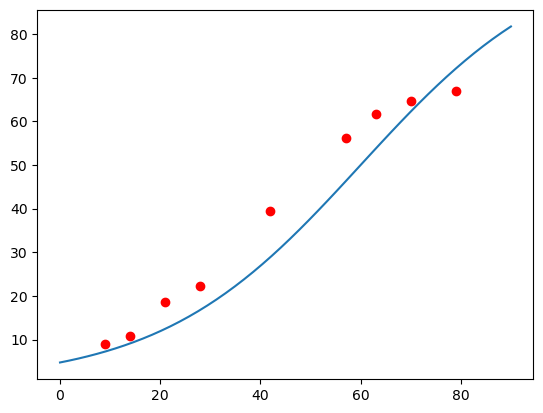

In [4]:
x_model = np.linspace(0, 90)
y_model = model(x_model, b1=100, b2=3, b3=0.05)
df_model = pd.DataFrame({"x": x_model, "y": y_model})
plt.plot(x_model, y_model, label="model")
plt.scatter(df["x"], df["y"], color="red");


## scipy.optimize.curve_fit

Let's try [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) ...

In [5]:
import scipy.optimize

In [6]:
p0=[100, 3, 0.05]
popt, pcov = scipy.optimize.curve_fit(f=model, xdata=df["x"], ydata=df["y"], p0=p0)

In [7]:
popt

array([7.24622290e+01, 2.61807707e+00, 6.73592165e-02])

In [8]:
np.sqrt(np.diag(pcov))

array([1.73404463, 0.08829482, 0.00344655])

That's it? All done? Does the model curve with optimal parameters `popt` fit better to the data than with initial guess `p0`?

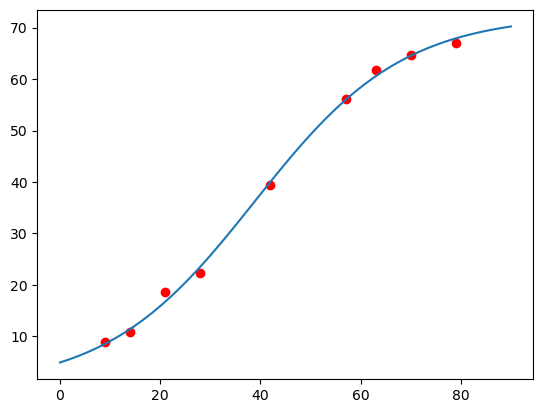

In [9]:
x_model = np.linspace(0, 90)
y_model = model(x_model, *popt)
df_model = pd.DataFrame({"x": x_model, "y": y_model})
plt.plot(x_model, y_model, label="model")
plt.scatter(df["x"], df["y"], color="red");

Looks like it's a good fit.

## lmfit

Let's try [lmfit](https://lmfit.github.io/lmfit-py) ...

In [10]:
import lmfit

In [11]:
lmfit_model = lmfit.Model(model)

In [12]:
p0 = {"b1": 100, "b2": 3, "b3": 0.05}
lmfit_result = lmfit_model.fit(data=df["y"], x=df["x"], **p0)

In [13]:
lmfit_result

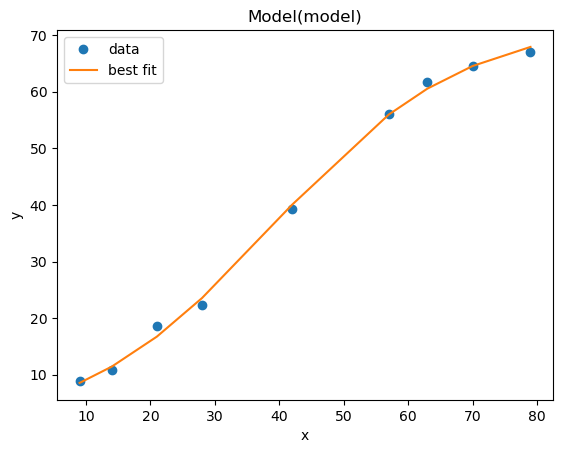

In [14]:
lmfit_result.plot_fit();

## iminuit

Let's try [iminuit](https://scikit-hep.org/iminuit) ...

In [15]:
import iminuit
import iminuit.cost

In [16]:
cost = iminuit.cost.LeastSquares(x=df["x"], y=df["y"], yerror=1, model=model)

In [17]:
minuit = iminuit.Minuit(cost, b1=100, b2=3, b3=0.05)

In [18]:
minuit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.057 (χ²/ndof = 1.3)      │              Nfcn = 116              │
│ EDM = 1.78e-07 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b1   │   72.5    │    1.5    │            │            │         │         │       │
│ 1 │ b2   │   2.62    │   0.08    │            │            │         │         │       │
│ 2 │ b3   │  0.0674   │  0.0029   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────┐
│    │        b1        b2        b3 │
├────┼───────────────────────────────┤
│ b1 │      2.12    -0.049 -3.511e-3 │
│ b2 │    -0.049   0.00578    181e-6 │
│ b3 │ -3.511e-3    181e-6  8.44e-06 │
└────┴───────────────────────────────┘

## sherpa

Let's try [sherpa](https://sherpa.readthedocs.io/) ...

In [19]:
import sherpa.data
import sherpa.models
import sherpa.fit

In [20]:
class MySherpaModel(sherpa.models.ArithmeticModel):
    def __init__(self, name='my_model'):
        self.b1 = sherpa.models.Parameter(name, 'b1', 100)
        self.b2 = sherpa.models.Parameter(name, 'b2', 3)
        self.b3 = sherpa.models.Parameter(name, 'b3', 0.05)
        return sherpa.models.ArithmeticModel.__init__(self, name, (self.b1, self.b2, self.b3))

    def calc(self, pars, *args):
        x = args[0]
        b1, b2, b3 = pars
        return model(x, b1, b2, b3)

In [21]:
sherpa_data = sherpa.data.Data1D('data', df["x"].values, df["y"].values)
sherpa_model = MySherpaModel()
sherpa_fit = sherpa.fit.Fit(data=sherpa_data, model=sherpa_model, stat=sherpa.stats.LeastSq())
sherpa_results = sherpa_fit.fit()

In [22]:
sherpa_model

<MySherpaModel model instance 'my_model'>

In [23]:
sherpa_results

Parameter,Best-fit value,Approximate error
my_model.b1,72.4629,± 1.49567
my_model.b2,2.61804,± 0.0762645
my_model.b3,0.0673576,± 0.00297561


For some reason the Jupyter notebook HTML output of Sherpa models and fit results doesn't render properly on Github (see [issue](https://github.com/sherpa/sherpa/issues/2082)).

But it works fine if you run the code locally in VS Code or a Jupyter notebook. The main idea of this tutorial is to give you an example to play around with anyways. Do it!

## astropy.modeling

In [24]:
import astropy.modeling

In [25]:
class MyAstropyModel(astropy.modeling.Fittable1DModel):
    b1 = astropy.modeling.Parameter(default=100)
    b2 = astropy.modeling.Parameter(default=3)
    b3 = astropy.modeling.Parameter(default=0.05)

    @staticmethod
    def evaluate(x, b1, b2, b3):
        return model(x, b1, b2, b3)

In [26]:
astropy_model = MyAstropyModel()
astropy_fitter = astropy.modeling.fitting.LevMarLSQFitter()
astropy_model = astropy_fitter(astropy_model, x=df["x"], y=df["y"])

In [27]:
astropy_model

<MyAstropyModel(b1=72.46245824, b2=2.61806485, b3=0.06735866)>

In [28]:
astropy_model.parameters

array([7.24624582e+01, 2.61806485e+00, 6.73586580e-02])

In [29]:
np.sqrt(np.diag(astropy_fitter.fit_info["param_cov"]))

array([1.73371334, 0.08832278, 0.00344709])

## Other options

All of the examples above are using Numpy arrays for the data and model evaluation and gradient-free optimisation where the optimiser only sees function values and steps around to estimate gradients and curvatures.

It is possible to use for example [pytorch](https://pytorch.org/) or [jax](https://jax.readthedocs.io/) which offer faster execution on CPU and access to GPU, and automatic differentiation for gradient-based optimisation. This can make the fit faster and more robust. But they are more complex and less widely known than Numpy, so usually Numpy is a good starting point and then only if needed you rewrite the code in JAX or PyTorch. If you're interested in this see [optax](https://optax.readthedocs.io/) or [iminuit](https://scikit-hep.org/iminuit/notebooks/automatic_differentiation.html).


## Summary and conclusions

We showed a toy example fit using these tools: scipy.optimize.curve_fit, lmfit, iminuit, sherpa, astropy.modeling.


They all give the correct certified result for [Rat42](https://www.itl.nist.gov/div898/strd/nls/data/ratkowsky2.shtml) in terms of optimal parameters and get the job done with a few lines of code.

If you look closely at the reported parameter covariance and standard errors you will see that scipy/lmfit/astropy give the certified values but iminuit/sherpa give a bit smaller numbers. This has to do with a difference in definition of the cost function related to assumptions on error scaling of the y values in the data. We will not discuss it in these tutorials, but if it's relevant to you see the documentation of the "absolute_sigma" option to [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

They are all strangely different in terms of concepts and the API how they are used. Some have data objects others don't. Some have model objects others don't. Some have least-squares cost function objects other don't. Some have fit or fitter objects others don't. Some modify input models or objects when calling fit, others leave the inputs untouched and return model results or other results objects.

So likely at this point you just find most of them confusing and useless and just want to go back to using scipy.optimize. On the other hand, lmfit and iminuit seem to have nice reporting of fit results. And maybe having model and parameter objects like in Astropy or Sherpa could be useful? Somewhat sceptical about this tutorial, you decide you want to learn more and give it another chance and move on to part 2.